In [2]:
import sys
import matplotlib
from getdist import plots, MCSamples
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
import pdb
import scipy.optimize as op
import scipy.special as spsp
from getdist.paramnames import escapeLatex, makeList, mergeRenames
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
import getdist
%matplotlib inline

In [3]:
def get_nsample(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#nsample="):
                nsamples = int(ln[9:])
    return nsamples

def get_evidence(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#log_z="):
                logz = float(ln[7:])
    return logz

def get_param_names(filename):
    with open(filename,"r") as fi:
        param_names = np.array((fi.readline()[1:].split()))
    return param_names


def get_S8(data, names, Omega_m_name = 'cosmological_parameters--omega_m', sigma_8_name = 'COSMOLOGICAL_PARAMETERS--SIGMA_8', alpha=0.5):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_m_name]):
            Omega_m_ind = ii
        if (names[ii] in [sigma_8_name]):
            sig8_ind = ii
    sigma_8 = data[:,sig8_ind]
    omega_m = data[:,Omega_m_ind]
    s8 = sigma_8 * (omega_m/0.3)**alpha
    return s8

def get_Obh2(data, names, Omega_b_name = 'cosmological_parameters--omega_b', h_name = 'cosmological_parameters--h0'):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_b_name]):
            Omega_b_ind = ii
        if (names[ii] in [h_name]):
            h_ind = ii
    h0 = data[:,h_ind]
    omega_b = data[:,Omega_b_ind]
    return omega_b * (h0**2)

def get_Omh3(data, names, Omega_m_name = 'cosmological_parameters--omega_m', h_name = 'cosmological_parameters--h0'):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in [Omega_m_name]):
            Omega_m_ind = ii
        if (names[ii] in [h_name]):
            h_ind = ii
    h0 = data[:,h_ind]
    omega_m = data[:,Omega_m_ind]
    return omega_m * (h0**3)

def get_max_2dpost(g, root, param1='cosmological_parameters--omega_m', param2='cosmological_parameters--s8',param_pair = None):
    param_pair = g.get_param_array(root, param_pair or [param1, param2])
    
    density = g.sample_analyser.get_density_grid(root, param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)
    xyind = np.where(density.P == np.amax(density.P))
    return density.y[xyind[0][0]],density.x[xyind[1][0]]
    
def get_contour_line(sigma_contour,g, density):

    contours = spsp.erf(sigma_contour/np.sqrt(2))
    density.contours = density.getContourLevels([contours])
    contour_levels = density.contours
    fig1, ax1 = pl.subplots(1)
    cs = pl.contour(density.x, density.y, density.P, sorted(contour_levels))
    lines = []
    for line in cs.collections[0].get_paths():
        lines.append(line.vertices)
    pl.close()
    return lines

def get_dmin(line, xref, yref):
    linex = line[0][:,0]
    liney = line[0][:,1]
    d_all = np.sqrt((linex - xref)**2 + (liney - yref)**2)
    dmin = np.amin(d_all)
    return dmin

def lefthand(sigma_contour, g, density, xref, yref): 
    line = get_contour_line(sigma_contour,g, density)
    result = get_dmin(line, xref, yref)  
    return result

lefthand = np.vectorize(lefthand)
   
def diff(sigma_contour, g, density, xref, yref):
    result = lefthand(sigma_contour, g, density, xref, yref)
    return result

def root_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.root(nll,np.array([init_x]),args=args,options={'maxfev':50})
    return result

def min_find(init_x,g, density, xref, yref): 
    nll = lambda *args: diff(*args)
    args = (g, density, xref, yref)
    result = op.fmin(nll,np.array([init_x]),args=args)
    return result
 
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))   

def get_frac_angle(start_coord, end_coord,xlims, ylims):
    xmean12 = (0.5*(start_coord[0] + end_coord[0]))
    ymean12 = (0.5*(start_coord[1] + end_coord[1]))
    dx = xlims[1] - xlims[0]
    dy = ylims[1] - ylims[0]
    dxp = xmean12 - end_coord[0]
    dyp = ymean12 - end_coord[1]
    angle_deg = 180.+ np.arctan2((end_coord[1]-start_coord[1])/dy,( end_coord[0]-start_coord[0])/dx)*(180./np.pi)
    return xmean12-dxp/2, ymean12+dyp/3, angle_deg

def replace_fancy(names, fancy_dic):
    output_names = []
    ind_data = []
    for ii in range(len(names)):
        if (names[ii] in fancy_dic):
            output_names.append(fancy_dic[names[ii]])
            ind_data.append(ii)
    return np.array(output_names), np.array(ind_data)


In [5]:
Om = 0.3
sigma8 = 0.82355 # what is this?
s8v = sigma8*np.sqrt(Om/0.3) 

# Truth values of various parameters
marker_dict = {'cosmological_parameters--omega_m':Om,'COSMOLOGICAL_PARAMETERS--SIGMA_8':sigma8,
               'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,
               'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0}    

chaindir = '/project/chihway/chihway/CosmicShearCosmosis/analysis/delve-campaign/'


Chain = ['fiducial', 'fiducial contaminated', 'fiducial no cut', 'fiducial no cut contaminated', 
         'fiducial halofit', 'fiducial halofit contaminated', 'fiducial TATT', 'fiducial TATT contaminated']
filename_list = [
    chaindir+'sim_fiducial-cuts_20240901/fiducial-cuts.txt',
    chaindir+'sim_baryon-contam-fiducial-cuts_20240901/baryon-contam-fiducial-cuts.txt', 
    chaindir+'sim_nocuts_20240901/nocuts.txt',
    chaindir+'sim_baryon-contam-nocuts_20240901/baryon-contam-nocuts.txt',
    chaindir+'sim_fiducial-cuts-halofit_20240901/fiducial-cuts-halofit.txt',
    chaindir+'sim_baryon-contam-fiducial-cuts-halofit_20240901/baryon-contam-fiducial-cuts-halofit.txt',
    chaindir+'sim_TATT-fiducial-cuts_20240901/TATT-fiducial-cuts.txt',
    chaindir+'sim_baryon-contam-TATT-fiducial-cuts_20240901/baryon-contam-TATT-fiducial-cuts.txt',] 

# potential parameters to analyze in 2D plots. Make sure they are here. The syntax is the (parameter_name_in_chain:latex_name)
fancy_dictionary = {'cosmological_parameters--omega_m':r'$\Omega_m$','cosmological_parameters--s8':r'$S_8$','cosmological_parameters--w':r'$w_0$'}  

all_data = []
all_samples = []

# Build getdist samples for above parameters
for jf in range(len(filename_list)):
    filename = filename_list[jf]
    nsample = get_nsample(filename)
    data = np.loadtxt(filename)[-nsample:,:]
    weights = np.loadtxt(filename)[-nsample:,-1]
    param_names = get_param_names(filename)
    s8 = get_S8(data, param_names).reshape(data.shape[0],1)
    data = np.hstack((data,s8 ))
    param_names = np.append(param_names,'cosmological_parameters--s8')
    param_names_fancy, selection = replace_fancy(np.array(param_names), fancy_dictionary)
    
    data = data[:,selection]
    param_names = param_names[selection]
    param_names_fancy = param_names_fancy
    all_data.append(data)

    samples = MCSamples(samples=data,weights=weights,names=param_names,labels=param_names_fancy)
    all_samples.append(samples)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [6]:
roots = makeList(all_samples)

# Which parameters to plot in the 2D plot
param1 = 'cosmological_parameters--omega_m'
param2 = 'cosmological_parameters--s8'
xlabels=[r'$\Omega_m$',r'$S_8$']


# dx = np.absolute(xlims[1] - xlims[0])
# dy = np.absolute(ylims[1] - ylims[0])

In [7]:
def get_scalecut_shift(i,j, xlims=[0.27,0.37], ylims=[0.77,0.88]):
    
    xlims = xlims
    ylims = ylims
    
    print(Chain[i], 'vs.', Chain[j])
    
    g = plots.getSinglePlotter()

    param2_cont, param1_cont = get_max_2dpost(g, roots[j],param1=param1, param2=param2)
    param2_base, param1_base = get_max_2dpost(g, roots[i],param1=param1, param2=param2)
    param1_truth, param2_truth = marker_dict[param1], marker_dict[param2]
    print(param1_truth, param1_base, param1_cont)
    print(param2_truth, param2_base, param2_cont)

    param_pair = g.get_param_array(roots[i], None or [param1, param2])

    density = g.sample_analyser.get_density_grid(roots[i], param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)

    g = plots.getSinglePlotter()
    density_cont = g.sample_analyser.get_density_grid(roots[j], param_pair[0], param_pair[1],
                                                                conts=g.settings.num_plot_contours,
                                                                likes=g.settings.shade_meanlikes)


    # Get the 2D distance in terms of sigma. In case you get some weird getdist error, change the starting guess value (here 0.01)
    res_truth_base = min_find(0.01,g, density, param1_truth, param2_truth)
    print(res_truth_base)
    res_cont_base = min_find(0.01,g, density_cont, param1_base, param2_base)
    print(res_cont_base)
    res_base_cont = min_find(0.01,g, density, param1_cont, param2_cont)
    print(res_base_cont)
    res_truth_cont = min_find(0.01,g, density_cont, param1_truth, param2_truth)
    print(res_truth_cont)

    line = get_contour_line(0.3,g, density)
    line_cont = get_contour_line(0.3,g, density_cont)

    fig, ax = pl.subplots(1, figsize=(8,6))
    ax.axvline(param1_truth,ls='--',alpha=0.3,color='k')
    ax.axhline(param2_truth,ls='--',alpha=0.3,color='k')

    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    ax.plot([param1_cont],[param2_cont], linestyle='', marker='o', color='b',label='Contaminated')
    ax.plot([param1_base],[param2_base], linestyle='', marker='s', color='r',label='Baseline')
    ax.plot(line[0][:,0],line[0][:,1], linestyle='--', marker='',lw=1, color='red',label=r'$0.3 \sigma$ Baseline')
    ax.plot(line_cont[0][:,0],line_cont[0][:,1], linestyle='--', marker='',lw=1, color='blue',label=r'$0.3 \sigma$ Contaminated')

    ax.annotate('', xy=(param1_truth, param2_truth), xytext=(param1_base, param2_base),
                arrowprops={'arrowstyle': '->'}, va='center')
    ax.annotate('', xy=(param1_truth, param2_truth), xytext=(param1_cont, param2_cont),
                arrowprops={'arrowstyle': '->'}, va='center')
    ax.annotate('', xy=(param1_base, param2_base), xytext=(param1_cont, param2_cont),
                arrowprops={'arrowstyle': '->'}, va='center')
    # ax.annotate('', xy=(param1_cont, param2_cont), xytext=(param1_base, param2_base),
    #             arrowprops={'arrowstyle': '->'}, va='center')

    ax.set_xlabel(xlabels[0], size = 22)
    ax.set_ylabel(xlabels[1], size = 22)
    ax.legend(fontsize=17,loc='lower right')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)

    # you might need to change the fracx, fracy by a little bit for the text to not overlap with the lines and show correctly around arrows
    # Also you might need to rotate the angle by 180 to have correct orientation

    # fracx, fracy, angle = get_frac_angle(np.array([param1_base,param2_base]),np.array([param1_cont, param2_cont]),xlims, ylims)
    # ax.text( fracx, fracy,str(np.round(res_base_cont[0],2)) + r'$\sigma$', verticalalignment='top', rotation=angle, horizontalalignment='left', transform=ax.transAxes, fontsize=16)    
    fracx, fracy, angle = get_frac_angle(np.array([param1_cont, param2_cont]),np.array([param1_base,param2_base]),xlims, ylims)
    ax.text( fracx, fracy,str(np.round(res_cont_base[0],2)) + r'$\sigma$', rotation=angle, fontsize=13) 
    fracx, fracy, angle = get_frac_angle(np.array([param1_base,param2_base]), np.array([param1_truth, param2_truth]),xlims, ylims)
    ax.text( fracx, fracy,str(np.round(res_truth_base[0],2)) + r'$\sigma$',  rotation=angle, fontsize=13)    
    fracx, fracy, angle = get_frac_angle(np.array([param1_cont, param2_cont]),np.array([param1_truth,param2_truth]),xlims, ylims)
    ax.text( fracx, fracy,str(np.round(res_truth_cont[0],2)) + r'$\sigma$', rotation=angle, fontsize=13) 



fiducial vs. fiducial contaminated
0.3 0.2961972272850238 0.30782308144827514
0.82355 0.833218436697834 0.824306544325605


/home/chihway/ipykernel_2942609/181610582.py:75: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs.collections[0].get_paths():


Optimization terminated successfully.
         Current function value: 0.000575
         Iterations: 19
         Function evaluations: 38
[0.110875]
Optimization terminated successfully.
         Current function value: 0.000590
         Iterations: 16
         Function evaluations: 32
[0.089375]
Optimization terminated successfully.
         Current function value: 0.001285
         Iterations: 18
         Function evaluations: 36
[0.06075]
Optimization terminated successfully.
         Current function value: 0.000454
         Iterations: 14
         Function evaluations: 28
[0.0410625]


<Figure size 600x450 with 0 Axes>

<Figure size 600x450 with 0 Axes>

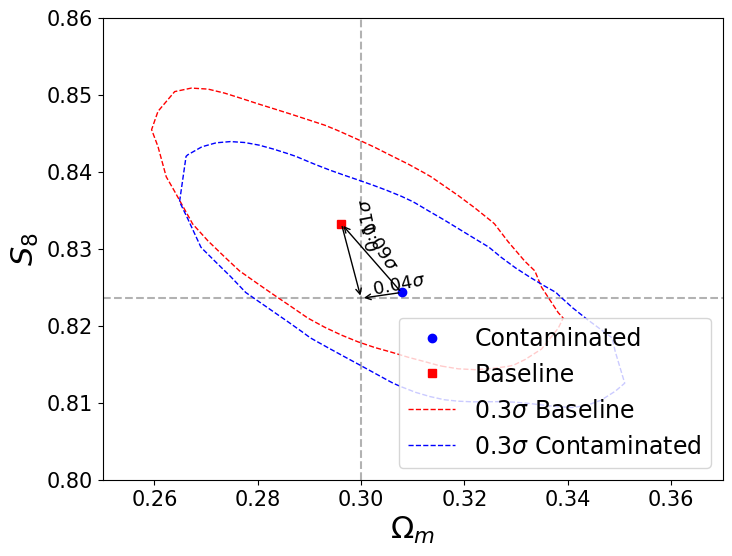

In [8]:
get_scalecut_shift(0,1, [0.25,0.37], [0.80,0.86])

fiducial no cut vs. fiducial no cut contaminated
0.3 0.28112807578079213 0.29116657973572785
0.82355 0.8382691477571286 0.8194372246573868


/home/chihway/ipykernel_2942609/181610582.py:75: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs.collections[0].get_paths():


Optimization terminated successfully.
         Current function value: 0.000987
         Iterations: 23
         Function evaluations: 46
[0.6435]
Optimization terminated successfully.
         Current function value: 0.000478
         Iterations: 25
         Function evaluations: 50
[1.3215625]
Optimization terminated successfully.
         Current function value: 0.001096
         Iterations: 25
         Function evaluations: 50
[1.100125]
Optimization terminated successfully.
         Current function value: 0.000727
         Iterations: 21
         Function evaluations: 42
[0.3418125]


<Figure size 600x450 with 0 Axes>

<Figure size 600x450 with 0 Axes>

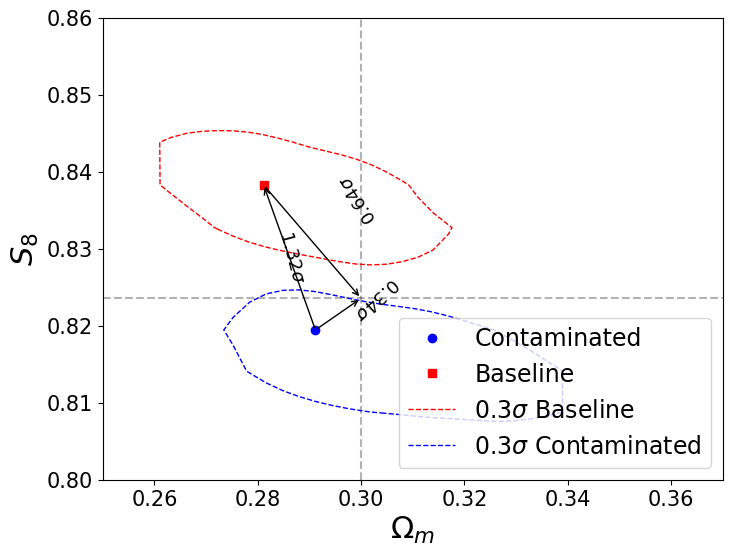

In [9]:
get_scalecut_shift(2,3, [0.25,0.37], [0.80,0.86])

fiducial halofit vs. fiducial halofit contaminated
0.3 0.30996085778062143 0.31174555415333927
0.82355 0.8167554293602153 0.8113701171338639


/home/chihway/ipykernel_2942609/181610582.py:75: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs.collections[0].get_paths():


Optimization terminated successfully.
         Current function value: 0.000898
         Iterations: 15
         Function evaluations: 30
[0.065875]
Optimization terminated successfully.
         Current function value: 0.000155
         Iterations: 13
         Function evaluations: 26
[0.037625]
Optimization terminated successfully.
         Current function value: 0.000730
         Iterations: 16
         Function evaluations: 34
[0.0745625]
Optimization terminated successfully.
         Current function value: 0.000298
         Iterations: 18
         Function evaluations: 36
[0.1550625]


<Figure size 600x450 with 0 Axes>

<Figure size 600x450 with 0 Axes>

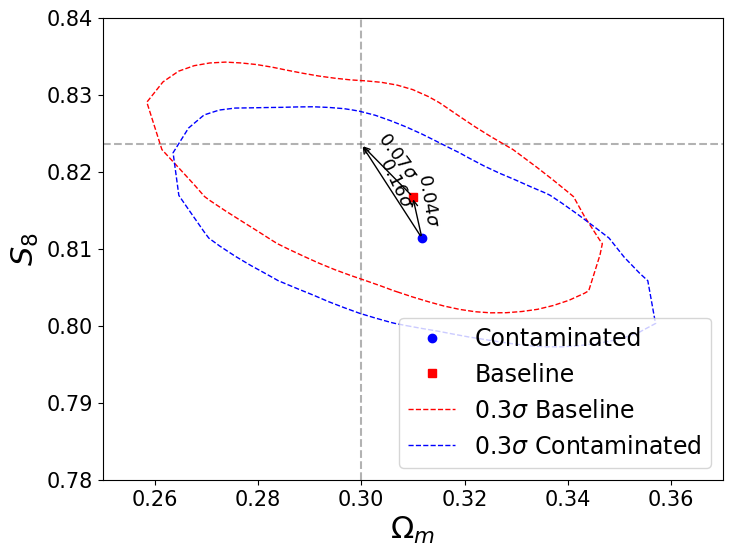

In [11]:
get_scalecut_shift(4,5, [0.25,0.37], [0.78,0.84])

fiducial TATT vs. fiducial TATT contaminated
0.3 0.2722226872988155 0.274581687920566
0.82355 0.8396445630616057 0.8345040061341326


/home/chihway/ipykernel_2942609/181610582.py:75: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for line in cs.collections[0].get_paths():


Optimization terminated successfully.
         Current function value: 0.000366
         Iterations: 18
         Function evaluations: 36
[0.1216875]
Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 14
         Function evaluations: 28
[0.032375]
Optimization terminated successfully.
         Current function value: 0.000133
         Iterations: 5
         Function evaluations: 10
[0.010875]
Optimization terminated successfully.
         Current function value: 0.000859
         Iterations: 15
         Function evaluations: 30
[0.0606875]


<Figure size 600x450 with 0 Axes>

<Figure size 600x450 with 0 Axes>

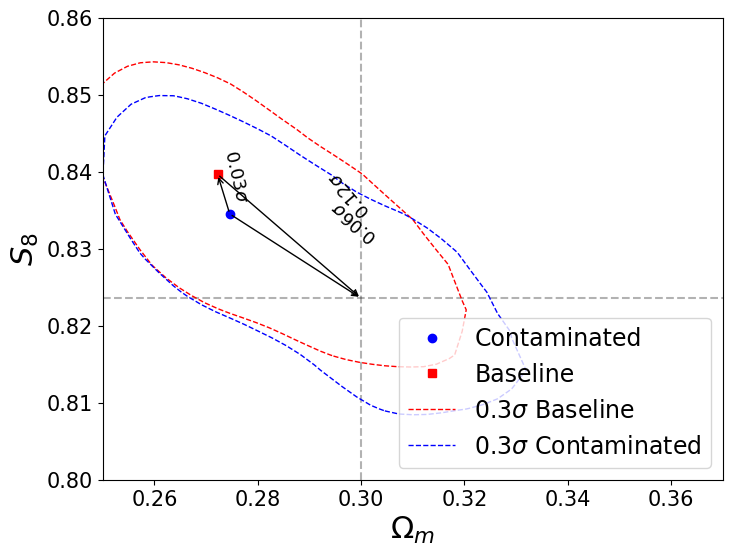

In [13]:
get_scalecut_shift(6,7, [0.25,0.37], [0.80,0.86])